# KNAP2 gene analysis

This notebook can be run locally or on a remote cloud computer by clicking the badge below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/statisticalbiotechnology/cb2030/master?filepath=nb%2Flinear%2FKNAP2.ipynb)


This example is taken from from [statomics](https://statomics.github.io).
Data from https://doi.org/10.1093/jnci/djj052


### Background
Histologic grade in breast cancer provides clinically important prognostic information. Researchers examined whether histologic grade was associated with gene expression profiles of breast cancers and whether such profiles could be used to improve histologic grading. In this tutorial we will assess the impact of histologic grade on expression of the KPNA2 gene that is known to be associated with poor BC prognosis. The patients, however, do not only differ in the histologic grade, but also on their lymph node status. The lymph nodes were not affected (0) or surgically removed (1). We first load our data.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.compat import urlopen

try:
    gene_table = pd.read_csv('brc.txt')
except:  # recent pandas can read URL without urlopen
    url = 'https://raw.githubusercontent.com/statOmics/statisticalGenomicsCourse/master/tutorial1/gse2990BreastcancerOneGene.txt'
    fh = urlopen(url)
    gene_table = pd.read_table(fh, sep=" ")
    gene_table.to_csv('brc.txt')
gene_table.drop(columns=['Unnamed: 0'], inplace=True)


# Analysis

We first log the KNAP2 gene expression values. It is common to assume a log normal distribution of transcription values. 

In [2]:
gene_table["log_gene"] = np.log(gene_table["gene"])
gene_table

,sample_name,grade,node,size,age,gene,log_gene
0,OXFT_2221,3,1,5.5,76,367.817935,5.907588
1,OXFT_209,3,1,2.5,66,590.357619,6.380728
2,OXFT_1769,1,1,3.5,86,346.658302,5.848340
3,OXFT_1770,1,1,1.7,69,258.445515,5.554685
4,OXFT_630,1,0,1.5,58,153.841583,5.035923
5,OXFT_1342,3,0,2.5,62,643.679906,6.467202
6,OXFT_2338,3,1,1.4,63,817.855820,6.706686
7,OXFT_2341,1,1,3.3,76,329.411333,5.797307
8,OXFT_1902,3,0,2.4,61,746.495081,6.615389
9,OXFT_2027,3,0,1.4,63,380.094029,5.940419


We first plot the exression values of the KNAP2 gene for grade 1 and grade 3 cancers, and compare the ones sitting in patients where lymph nodes are or ar not surgically removed. 

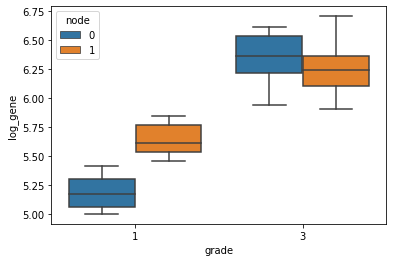

In [3]:
sns.boxplot(y="log_gene",x="grade",hue="node",data=gene_table)

Overall it seems like there is a large differnce in KNAP2 expression between grade 1 and grade 3 cancers. We test if the difference is significant.

In [4]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
formula = 'log_gene ~ C(grade)'
lm = ols(formula, gene_table).fit()
print(anova_lm(lm))

            df    sum_sq   mean_sq          F        PR(>F)
C(grade)   1.0  4.724248  4.724248  64.730133  5.372087e-08
Residual  22.0  1.605643  0.072984        NaN           NaN


The difference is indeed very significant.  

We expand the model to also test for differences for removed lymph nodes, as well as an interaction term between cancer grade and node removal.  

In [5]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
formula = 'log_gene ~ C(grade) + C(node) + C(grade):C(node)'
lm = ols(formula, gene_table).fit()
#print(lm.summary())
print(anova_lm(lm))

                    df    sum_sq   mean_sq          F        PR(>F)
C(grade)           1.0  4.724248  4.724248  98.180646  3.691090e-09
C(node)            1.0  0.210704  0.210704   4.378918  4.934337e-02
C(grade):C(node)   1.0  0.432580  0.432580   8.989996  7.102512e-03
Residual          20.0  0.962358  0.048118        NaN           NaN


All three terms are significant on a p<0.05 level. So there is a difference in expression between patients with and without surgicaly removed lymph nodes, between grade 1 and grade 3 tumors, and the two previously changes are linked. Visually, this makes sence by our previous boxplot, as the mean expression values of node 0/1 differ with differnt signs for grade 1 and grade 3 tumors.  

Now we continue by investigating if we can see any significant differences of KNAP2 expressions given their size.

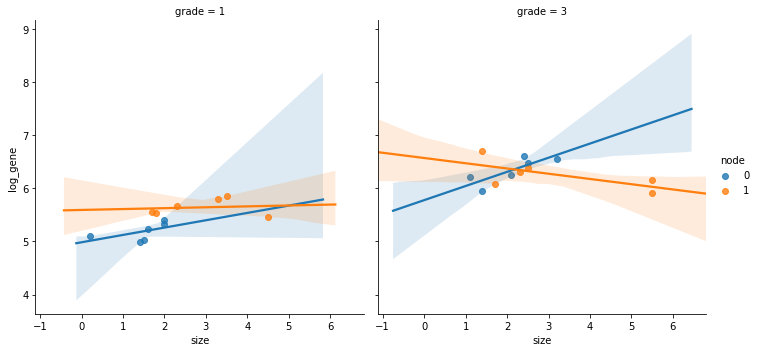

In [6]:
sns.lmplot(y="log_gene",x="size",hue="node",col="grade",data=gene_table)

We first test if there is a significant dependence on tumor size, first alone and subsequently also counting away the effects of the difference in grade and node status.

In [7]:
formula = 'log_gene ~ size'
lm2 = ols(formula, gene_table).fit()
print(anova_lm(lm2))

            df    sum_sq   mean_sq         F    PR(>F)
size       1.0  0.353502  0.353502  1.301295  0.266243
Residual  22.0  5.976388  0.271654       NaN       NaN


In [8]:
formula = 'log_gene ~ C(grade) + C(node) + size'
lm2 = ols(formula, gene_table).fit()
print(anova_lm(lm2))

            df    sum_sq   mean_sq          F        PR(>F)
C(grade)   1.0  4.724248  4.724248  67.820058  7.427185e-08
C(node)    1.0  0.210704  0.210704   3.024817  9.736925e-02
size       1.0  0.001767  0.001767   0.025364  8.750601e-01
Residual  20.0  1.393171  0.069659        NaN           NaN


In either of the tests the KNAP2 expression do not significantly depend on tumor size. We then see if there is an interaction between size and tumor grade.

In [9]:
formula = 'log_gene ~ C(grade) + size + size:C(grade)'
lm3 = ols(formula, gene_table).fit()
print(anova_lm(lm3))

                 df    sum_sq   mean_sq          F        PR(>F)
C(grade)        1.0  4.724248  4.724248  81.016482  1.801068e-08
size            1.0  0.034664  0.034664   0.594460  4.497132e-01
size:C(grade)   1.0  0.404735  0.404735   6.940825  1.589141e-02
Residual       20.0  1.166244  0.058312        NaN           NaN


The test suggest that KNAP2 expression depends on an interaction between tumor size and grade. 